In [1]:
import csv
import os
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
folder_to_name = {'hsbam': 'hsbam',
                  'wtF': 'wtF',
                  'wtJ': 'wtJ',
                  '96h': '96h',
                  'traffic_jam': 'tjdpp',
                  'bam_mutants': 'bam',
                  'oskar': 'osk'
                 }
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/raw data"
data_frames = {}

tech = 'cellranger'

for folder in folder_to_name:
    subfolder = folder_to_name[folder]
    matrix_dir = os.path.join(os.path.join(matrices_dir,subfolder), tech)
    mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx"))
 
    genes_path = os.path.join(matrix_dir, "genes.tsv")
    gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]
 
    barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")
    barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]
    arr=mat.toarray()
    df = pd.DataFrame(arr)
    df.index = gene_names
    df.columns = barcodes 
    data_frames[folder] = df

### Convert gene symbols to Gene ids

This section is taken directly from "Create TSV from Matrix"

In [3]:
gtf = pd.read_csv('~/Dev/Drosophila_inferelator/Drosophila_melanogaster.BDGP6.91.genes.gtf', sep='\t', header = None)
gene_sym_to_id = {}
gene_id_to_sym = {}
gtf.head()

,0,1,2,3,4,5,6,7,8
0,3R,FlyBase,gene,567076,2532932,.,+,.,"gene_id ""FBgn0267431""; gene_name ""Myo81F""; gen..."
1,3R,FlyBase,gene,722370,722621,.,-,.,"gene_id ""FBgn0085804""; gene_name ""CR41571""; ge..."
2,3R,FlyBase,gene,1031171,1031354,.,+,.,"gene_id ""FBgn0039987""; gene_name ""CR12798""; ge..."
3,3R,FlyBase,gene,1366234,1366601,.,-,.,"gene_id ""FBgn0267798""; gene_name ""CR46123""; ge..."
4,3R,FlyBase,gene,1865108,1866008,.,-,.,"gene_id ""FBgn0267797""; gene_name ""CR46122""; ge..."


In [4]:
for (idx, row) in gtf.iterrows():
    st = row[8]
    splits = st.split(';')
    i = splits[0].split(" ")[1].strip('"')
    sym = splits[1].split(" ")[2].strip('"').rstrip(';').rstrip('"').replace(';', '')
    gene_sym_to_id[sym] = i
    gene_id_to_sym[i] = sym 

In [5]:
def convert_df_from_Fbgn_ids_to_symbols(df):
    subset_index = set(gene_id_to_sym.keys()).intersection(df.index)
    if len(subset_index) == 0:
        print 'Error: No overlap found. Aborting'
        return
    new_index = [gene_id_to_sym[i] for i in subset_index]
    lost_genes = df.shape[0] - len(new_index)
    print 'Converting dataframe. Losing {} genes out of an index size of {}'.format(lost_genes, df.shape[0])
    df = df.loc[subset_index, :]
    df.index = new_index
    return df

def convert_df_from_symbols_to_Fbgn_ids(df):
    subset_index = set(gene_sym_to_id.keys()).intersection(df.index)
    if len(subset_index) == 0:
        print 'Error: No overlap found. Aborting'
        return
    new_index = [gene_sym_to_id[sym] for sym in subset_index]
    lost_genes = df.shape[0] - len(new_index)
    print 'Converting dataframe. Losing {} genes out of an index size of {}'.format(lost_genes, df.shape[0])
    df = df.loc[subset_index, :]
    df.index = new_index
    return df
def convert_col_from_Fbgn_ids_to_symbols(col):
    new_col = [gene_id_to_sym[i] if i in gene_id_to_sym.keys() else i for i in col]
    return new_col

In [6]:
df = data_frames['wtJ']

## Finding the top interactions discovered by the Inferelator

Let's first find the 100 most stable and strong relationships found by the inferelator. To do that, we'll take the top 100 by abs sum betas for the 0.3 to 0.8 cutoff

In [7]:
output_dir = '/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/outputs/dmel_expression_TF_filtered_experiment'  # dmel_TF_filtered_experiment'

In [8]:
first_last_folders =  ['2018-03-09_14-47-59', '2018-03-15_08-15-20']  # ['2018-03-06_14-21-10', '2018-03-06_17-42-47']
folders = os.listdir(output_dir)
relevant_folders = [i for i in sorted(folders) if (i >= first_last_folders[0]) & (i <= first_last_folders[1])]
relevant_folders

['2018-03-09_14-47-59',
 '2018-03-09_14-54-15',
 '2018-03-09_17-26-07',
 '2018-03-09_18-27-47',
 '2018-03-13_18-42-53',
 '2018-03-14_16-42-43',
 '2018-03-15_08-15-20']

In [9]:
# Generate networks
networks = {}
basename = 'cutoff_'
current_cutoff = .3
increment = .1
for i in relevant_folders:
    filename = os.path.join(os.path.join(output_dir, i), 'network.tsv')
    name = basename + str(current_cutoff)
    net = pd.read_csv(filename, sep='\t')
    networks[name] = net.copy()
    networks[name]['regulator'] = convert_col_from_Fbgn_ids_to_symbols(net['regulator'])
    networks[name]['target'] = convert_col_from_Fbgn_ids_to_symbols(net['target'])
    current_cutoff += increment
    networks[name].head()
    

In [10]:
relevant_cutoffs = list(networks.keys())
relevant_cutoffs.pop(-1)  # remove cutoff_0.9
relevant_cutoffs

['cutoff_0.6',
 'cutoff_0.7',
 'cutoff_0.4',
 'cutoff_0.5',
 'cutoff_0.3',
 'cutoff_0.8']

In [11]:
nets = networks.values()
combined_net = pd.concat(nets)

In [12]:
combined_net.shape

(133507, 7)

In [13]:
summed_net = combined_net.groupby(['regulator', 'target']).sum().sum(
    level=['regulator', 'target'])


In [14]:
top_interactions = summed_net.sort_values('beta.non.zero', ascending=False)[0:100]
top_interactions

beta.sign.sum  beta.non.zero  var.exp.median  \
regulator       target                                                    
mirr            lqf                140.0          140.0        1.211993   
brk             Btk29A             140.0          140.0        1.328028   
                pum                139.0          139.0        2.115727   
                Tet                135.0          135.0        1.466143   
Lmx1a           RpL7A             -134.0          134.0        1.174865   
brk             ATPsynG           -133.0          133.0        1.522061   
                ATPsynF           -132.0          132.0        1.441036   
                Ten-a              132.0          132.0        1.487609   
                Oda                132.0          132.0        1.524112   
                awd               -131.0          131.0        1.203812   
Xrp1            Moe                130.0          130.0        0.957073   
Lmx1a           RpS28b            -127.0          127.0        0.853481   
brk             Tpi               -126.0          126.0        1.159481   
                Ppn                126.0          126.0        1.320935   
                sick               126.0          126.0        1.123758   
                Atg8a              124.0          124.0        0.981324   
                fz2                123.0          123.0        1.433714   
aop             l(1)G0469          123.0          123.0        1.116056   
brk             Tsp96F             122.0          122.0        1.468356   
Lmx1a           sta               -122.0          122.0        1.128202   
mirr            hh                 121.0          121.0        1.129373   
E(spl)mbeta-HLH Xrp1               120.0          120.0        1.117813   
Lmx1a           CG17124            120.0          120.0        1.220269   
E(spl)mbeta-HLH RpS23              120.0          120.0        2.425434   
                RpS16              120.0          120.0        2.562697   
                RpL12              120.0          120.0        2.188069   
                RpS9               120.0          120.0        1.973583   
                RpL9               120.0          120.0        1.576905   
mirr            NetA               120.0          120.0        0.984934   
E(spl)mbeta-HLH RpS3               120.0          120.0        2.179281   
...                                  ...            ...             ...   
aop             CadN               110.0          110.0        1.274224   
brk             CG17265            110.0          110.0        0.934187   
E(spl)mbeta-HLH MRE16             -110.0          110.0        1.661188   
                RpL37A             110.0          110.0        0.845387   
Lmx1a           RpS24             -110.0          110.0        1.147703   
brk             CG17124            109.0          109.0        1.075881   
aop             CycG               109.0          109.0        0.731163   
E(spl)mbeta-HLH Fas2              -108.0          108.0        2.032345   
                RpL18              108.0          108.0        1.513417   
                RpL31              108.0          108.0        0.926871   
                RpS30              108.0          108.0        1.238720   
                RpL13              107.0          107.0        1.562516   
zld             chinmo             107.0          107.0        0.956777   
E(spl)mbeta-HLH mt:CoIII           107.0          107.0        1.212378   
                RpL13A             107.0          107.0        1.154162   
brk             CG11400            107.0          107.0        1.278043   
                ATPsynC           -107.0          107.0        0.874217   
                CG11267           -106.0          106.0        0.712875   
Eip78C          sbb                105.0          105.0        0.792598   
Mnt             CG42674            105.0          105.0        0.839564   
bab1            Col4a1             105.0          10

In [15]:
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/inputs/03_02_2018"
mat_file = 'TF_data.csv'
cca_data = pd.read_csv(os.path.join(matrices_dir, mat_file), sep=',', index_col  = 0) #sep='\t',


## Q1: Do linear relationships found in the Inferelator persist without CCA?

//anaconda/envs/py27.13/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0.98,'Correlation on CCA transformed data, combining wtF and wtJ')

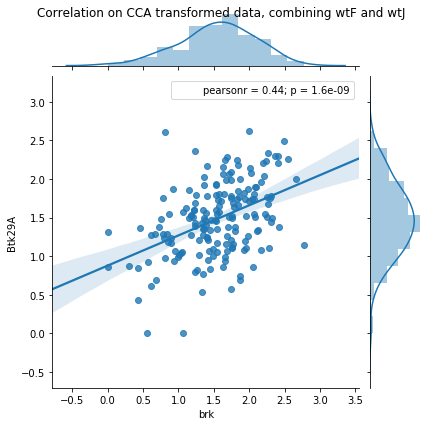

In [16]:
g = sns.jointplot("brk", "Btk29A", data=cca_data.transpose(), kind="reg")
g.fig.suptitle('Correlation on CCA transformed data, combining wtF and wtJ')

In [17]:
wtf_TF_columns = [c.split('_')[2] + '-1' for c in cca_data.columns if 'wtF' in c]
wtJ_TF_columns = [c.split('_')[2] + '-1' for c in cca_data.columns if 'wtJ' in c]

In [18]:
raw_data_TF_wtf = data_frames['wtF'][wtf_TF_columns]
raw_data_TF_wtJ = data_frames['wtJ'][wtJ_TF_columns]

Text(0.5,0.98,'Log Raw Data wtF')

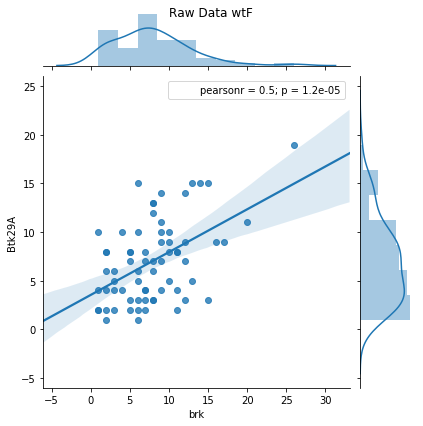

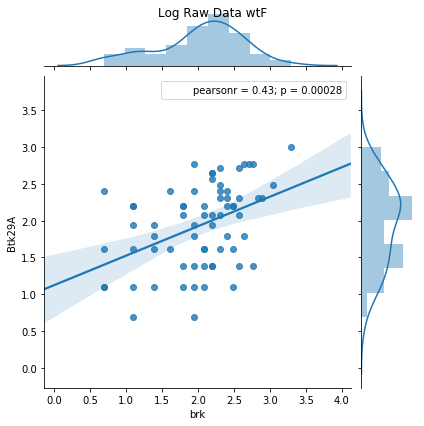

In [19]:
g = sns.jointplot("brk", "Btk29A", data=raw_data_TF_wtf.transpose(), kind="reg")
g.fig.suptitle('Raw Data wtF')
# Log
g = sns.jointplot("brk", "Btk29A", data=np.log(raw_data_TF_wtf.transpose()+1), kind="reg")
g.fig.suptitle('Log Raw Data wtF')

Q: Why is the correlation decreasing after linearizing by using a log transform? A: seems like the points in the lower left quadrant gain influence! Even tho the residuals are likely becoming normal, high variance low read count points have increased weight

Text(0.5,0.98,'Log Raw Data wtJ')

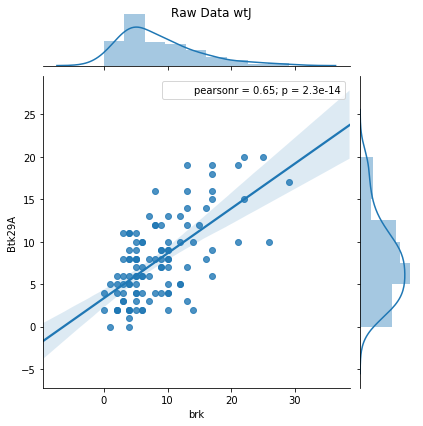

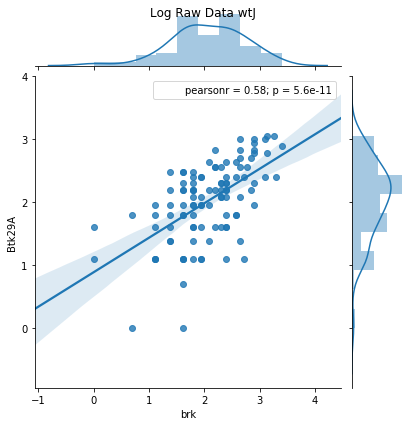

In [20]:
g = sns.jointplot("brk", "Btk29A", data=raw_data_TF_wtJ.transpose(), kind="reg")
g.fig.suptitle('Raw Data wtJ')

g = sns.jointplot("brk", "Btk29A", data=np.log(raw_data_TF_wtJ.transpose()+1), kind="reg")
g.fig.suptitle('Log Raw Data wtJ')

## Q2: Do linear relationships found in the Inferelator persist outside of the Terminal Filament Cells?

Text(0.5,0.98,'Raw Data wtF')

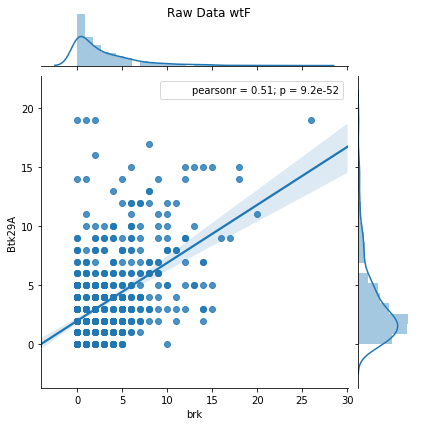

In [21]:
other_cols = list(set(data_frames['wtF']) -  set(wtf_TF_columns))
g = sns.jointplot("brk", "Btk29A", data=data_frames['wtF'].transpose(), kind="reg")
g.fig.suptitle('Raw Data wtF')

Text(0.5,0.98,'Raw Data wtJ')

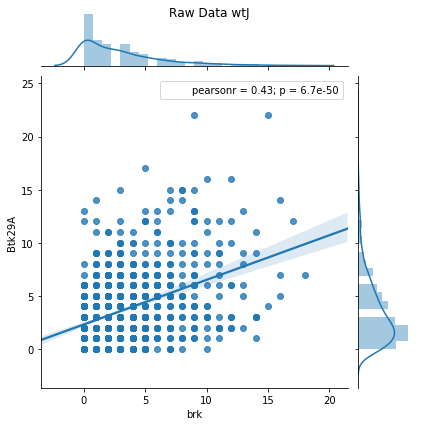

In [22]:
other_cols = list(set(data_frames['wtJ']) -  set(wtJ_TF_columns))
g = sns.jointplot("brk", "Btk29A", data=data_frames['wtJ'][other_cols].transpose(), kind="reg")
g.fig.suptitle('Raw Data wtJ')

## Q3: Is log-transformation the ideal relative to other power transforms? Let's use  BoxCox to check


In [23]:
infi = 0.00001
x = cca_data.transpose()['brk'].values + infi
# x = cca_data.transpose()['Btk29A'].values + infi
# x = raw_data_TF_wtf.transpose()['Btk29A'].values
# x = stats.loggamma.rvs(5, loc=10, size=1000)
lmbdas = np.linspace(-2, 10)
llf = np.zeros(lmbdas.shape, dtype=float)
for ii, lmbda in enumerate(lmbdas):
    llf[ii] = stats.boxcox_llf(lmbda, x)
    
x_most_normal, lmbda_optimal = stats.boxcox(x)

In [24]:
np.min(cca_data.transpose()['Btk29A'])

0.0

In [25]:
lmbda_optimal

0.93359328196183777

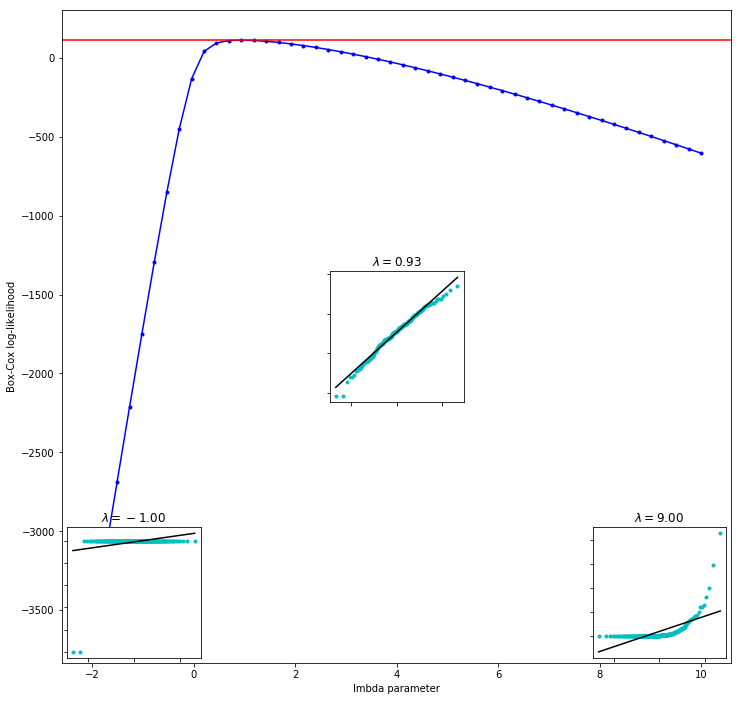

In [26]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(lmbdas, llf, 'b.-')
ax.axhline(stats.boxcox_llf(lmbda_optimal, x), color='r')
ax.set_xlabel('lmbda parameter')
ax.set_ylabel('Box-Cox log-likelihood')
locs = [3, 10, 4]  # 'lower left', 'center', 'lower right'
for lmbda, loc in zip([-1, lmbda_optimal, 9], locs):
    xt = stats.boxcox(x, lmbda=lmbda)
    (osm, osr), (slope, intercept, r_sq) = stats.probplot(xt)
    ax_inset = inset_axes(ax, width="20%", height="20%", loc=loc)
    ax_inset.plot(osm, osr, 'c.', osm, slope*osm + intercept, 'k-')
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])
    ax_inset.set_title('$\lambda=%1.2f$' % lmbda)
    
plt.show()

### If the log transformed data has an optimal boxcox lambda around 0, then a transformation is not needed
See https://en.wikipedia.org/wiki/Power_transform for more. lmbda_optimal for cca_data for Btk29A is 0.98, and for brk is 0.93

Text(0.5,1,'median log readcount')

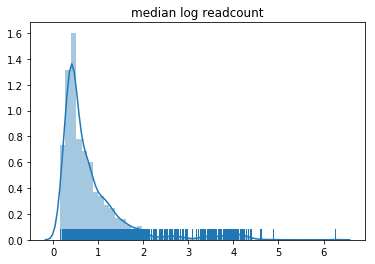

In [27]:
row_medians = cca_data.median(axis=1)
sns.distplot(row_medians[row_medians != 0], rug=True);
plt.title('median log readcount')

## Q4: How does median adjusting change the linear relationship?

In [28]:
def median_normalize(X):
    num_transcripts = np.sum(X, axis=0)
    T = (np.median(num_transcripts) / num_transcripts) * X
    return T

Text(0.5,0.98,'Median Normalized Log Data wtJ')

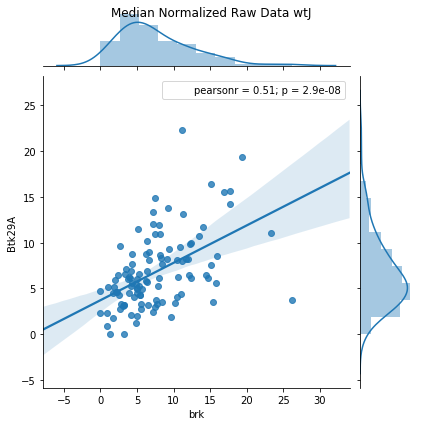

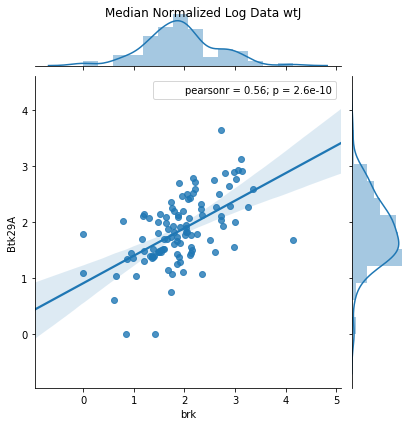

In [29]:
dat = raw_data_TF_wtJ
g = sns.jointplot("brk", "Btk29A", data=median_normalize(dat).transpose(), kind="reg")
g.fig.suptitle('Median Normalized Raw Data wtJ')

# Log
g = sns.jointplot("brk", "Btk29A", data=median_normalize(np.log(dat+1)).transpose(), kind="reg")
g.fig.suptitle('Median Normalized Log Data wtJ')

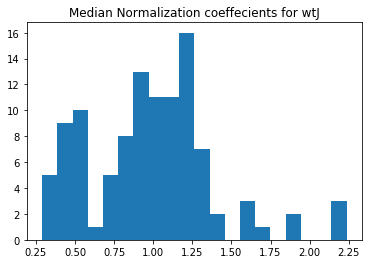

In [30]:
X = dat
num_transcripts = np.sum(X, axis=0)
median_vec = (np.median(num_transcripts) / num_transcripts)
plt.hist(median_vec, bins=20)
plt.title('Median Normalization coeffecients for wtJ')
plt.show()

In [31]:
len(median_vec)

107

Text(0.5,0.98,'Median Normalized Log Data wtF')

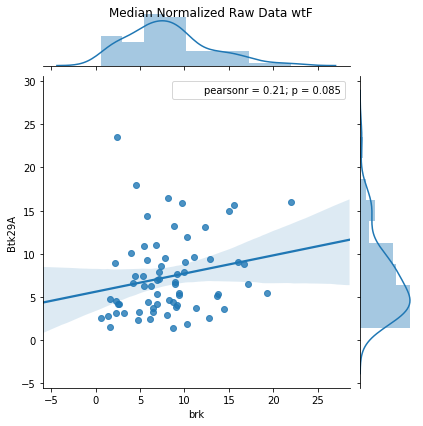

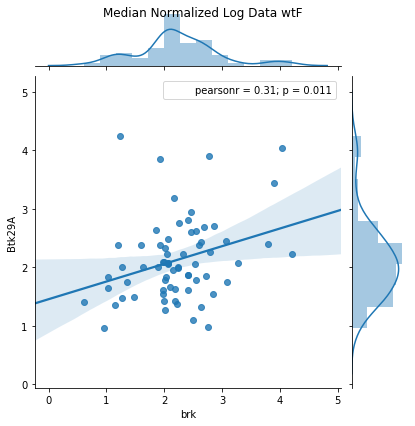

In [32]:
dat = raw_data_TF_wtf
g = sns.jointplot("brk", "Btk29A", data=median_normalize(dat).transpose(), kind="reg")
g.fig.suptitle('Median Normalized Raw Data wtF')

# Log
g = sns.jointplot("brk", "Btk29A", data=median_normalize(np.log(dat+1)).transpose(), kind="reg")
g.fig.suptitle('Median Normalized Log Data wtF')


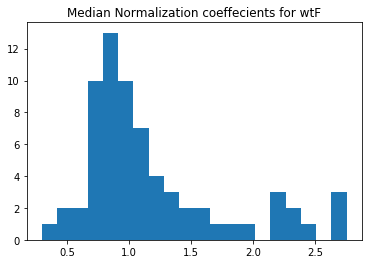

In [33]:
X = dat
num_transcripts = np.sum(X, axis=0)
median_vec = (np.median(num_transcripts) / num_transcripts)
plt.hist(median_vec, bins=20)
plt.title('Median Normalization coeffecients for wtF')
plt.show()

Compared to the linear trend without median normalization, the R squared here is weaker across the board, especially in the wtF data set. 

## Q5: How does knn smoothing change the data? Do the linear relationships persist?


Let's first do a heatmap visualization of the data before the knn smooting

In [34]:
filtered_exp = data_frames['wtJ']
percent_nonzero = (filtered_exp > 0).sum(axis = 1) / filtered_exp.shape[1]
percent_nonzero_filter = .95

In [35]:
num_genes_above_filter = []
increment = .001
cutoffs = [i * increment for i in range(1005) if i * increment <= 1]
for i in cutoffs:
    num_genes_above_filter.append(percent_nonzero[percent_nonzero > i].shape[0])

In [36]:
num_genes_above_filter_downsampled = []
increment = .1
cutoffs_downsampled = [i * increment for i in range(200) if (i * increment < 1 and  i * increment > .3)  ]
for i in cutoffs_downsampled:
    num_genes_above_filter_downsampled.append(percent_nonzero[percent_nonzero > i].shape[0])

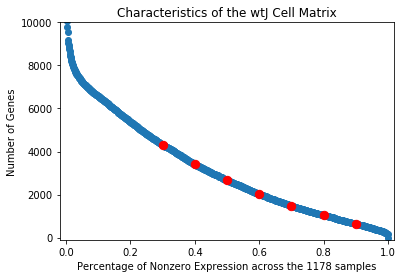

In [37]:
plt.scatter(cutoffs, num_genes_above_filter)
plt.scatter(cutoffs_downsampled, num_genes_above_filter_downsampled, c='red', s =70)
plt.xlabel('Percentage of Nonzero Expression across the {} samples'.format(filtered_exp.shape[1]))
plt.ylabel('Number of Genes')
plt.title('Characteristics of the wtJ Cell Matrix')
plt.ylim( (-100, 10000) )
plt.xlim((-.02, 1.02))
plt.show()

In [38]:
num_genes_above_filter_downsampled

[4314, 3400, 2667, 2021, 1485, 1048, 640]

In [39]:
filtered_exp_60 = filtered_exp.loc[percent_nonzero[percent_nonzero > .60].index, :]

In [40]:
filtered_exp_60.shape

(2021, 1178)

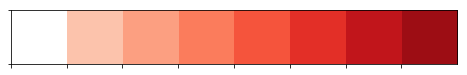

In [41]:
cmap = sns.color_palette("Reds", 8)
cmap[0] = 'white'
sns.palplot(cmap)

Text(0.5,1,'WTJ Terminal Filament data, across genes that are nonzero at 20%, log-scaled')

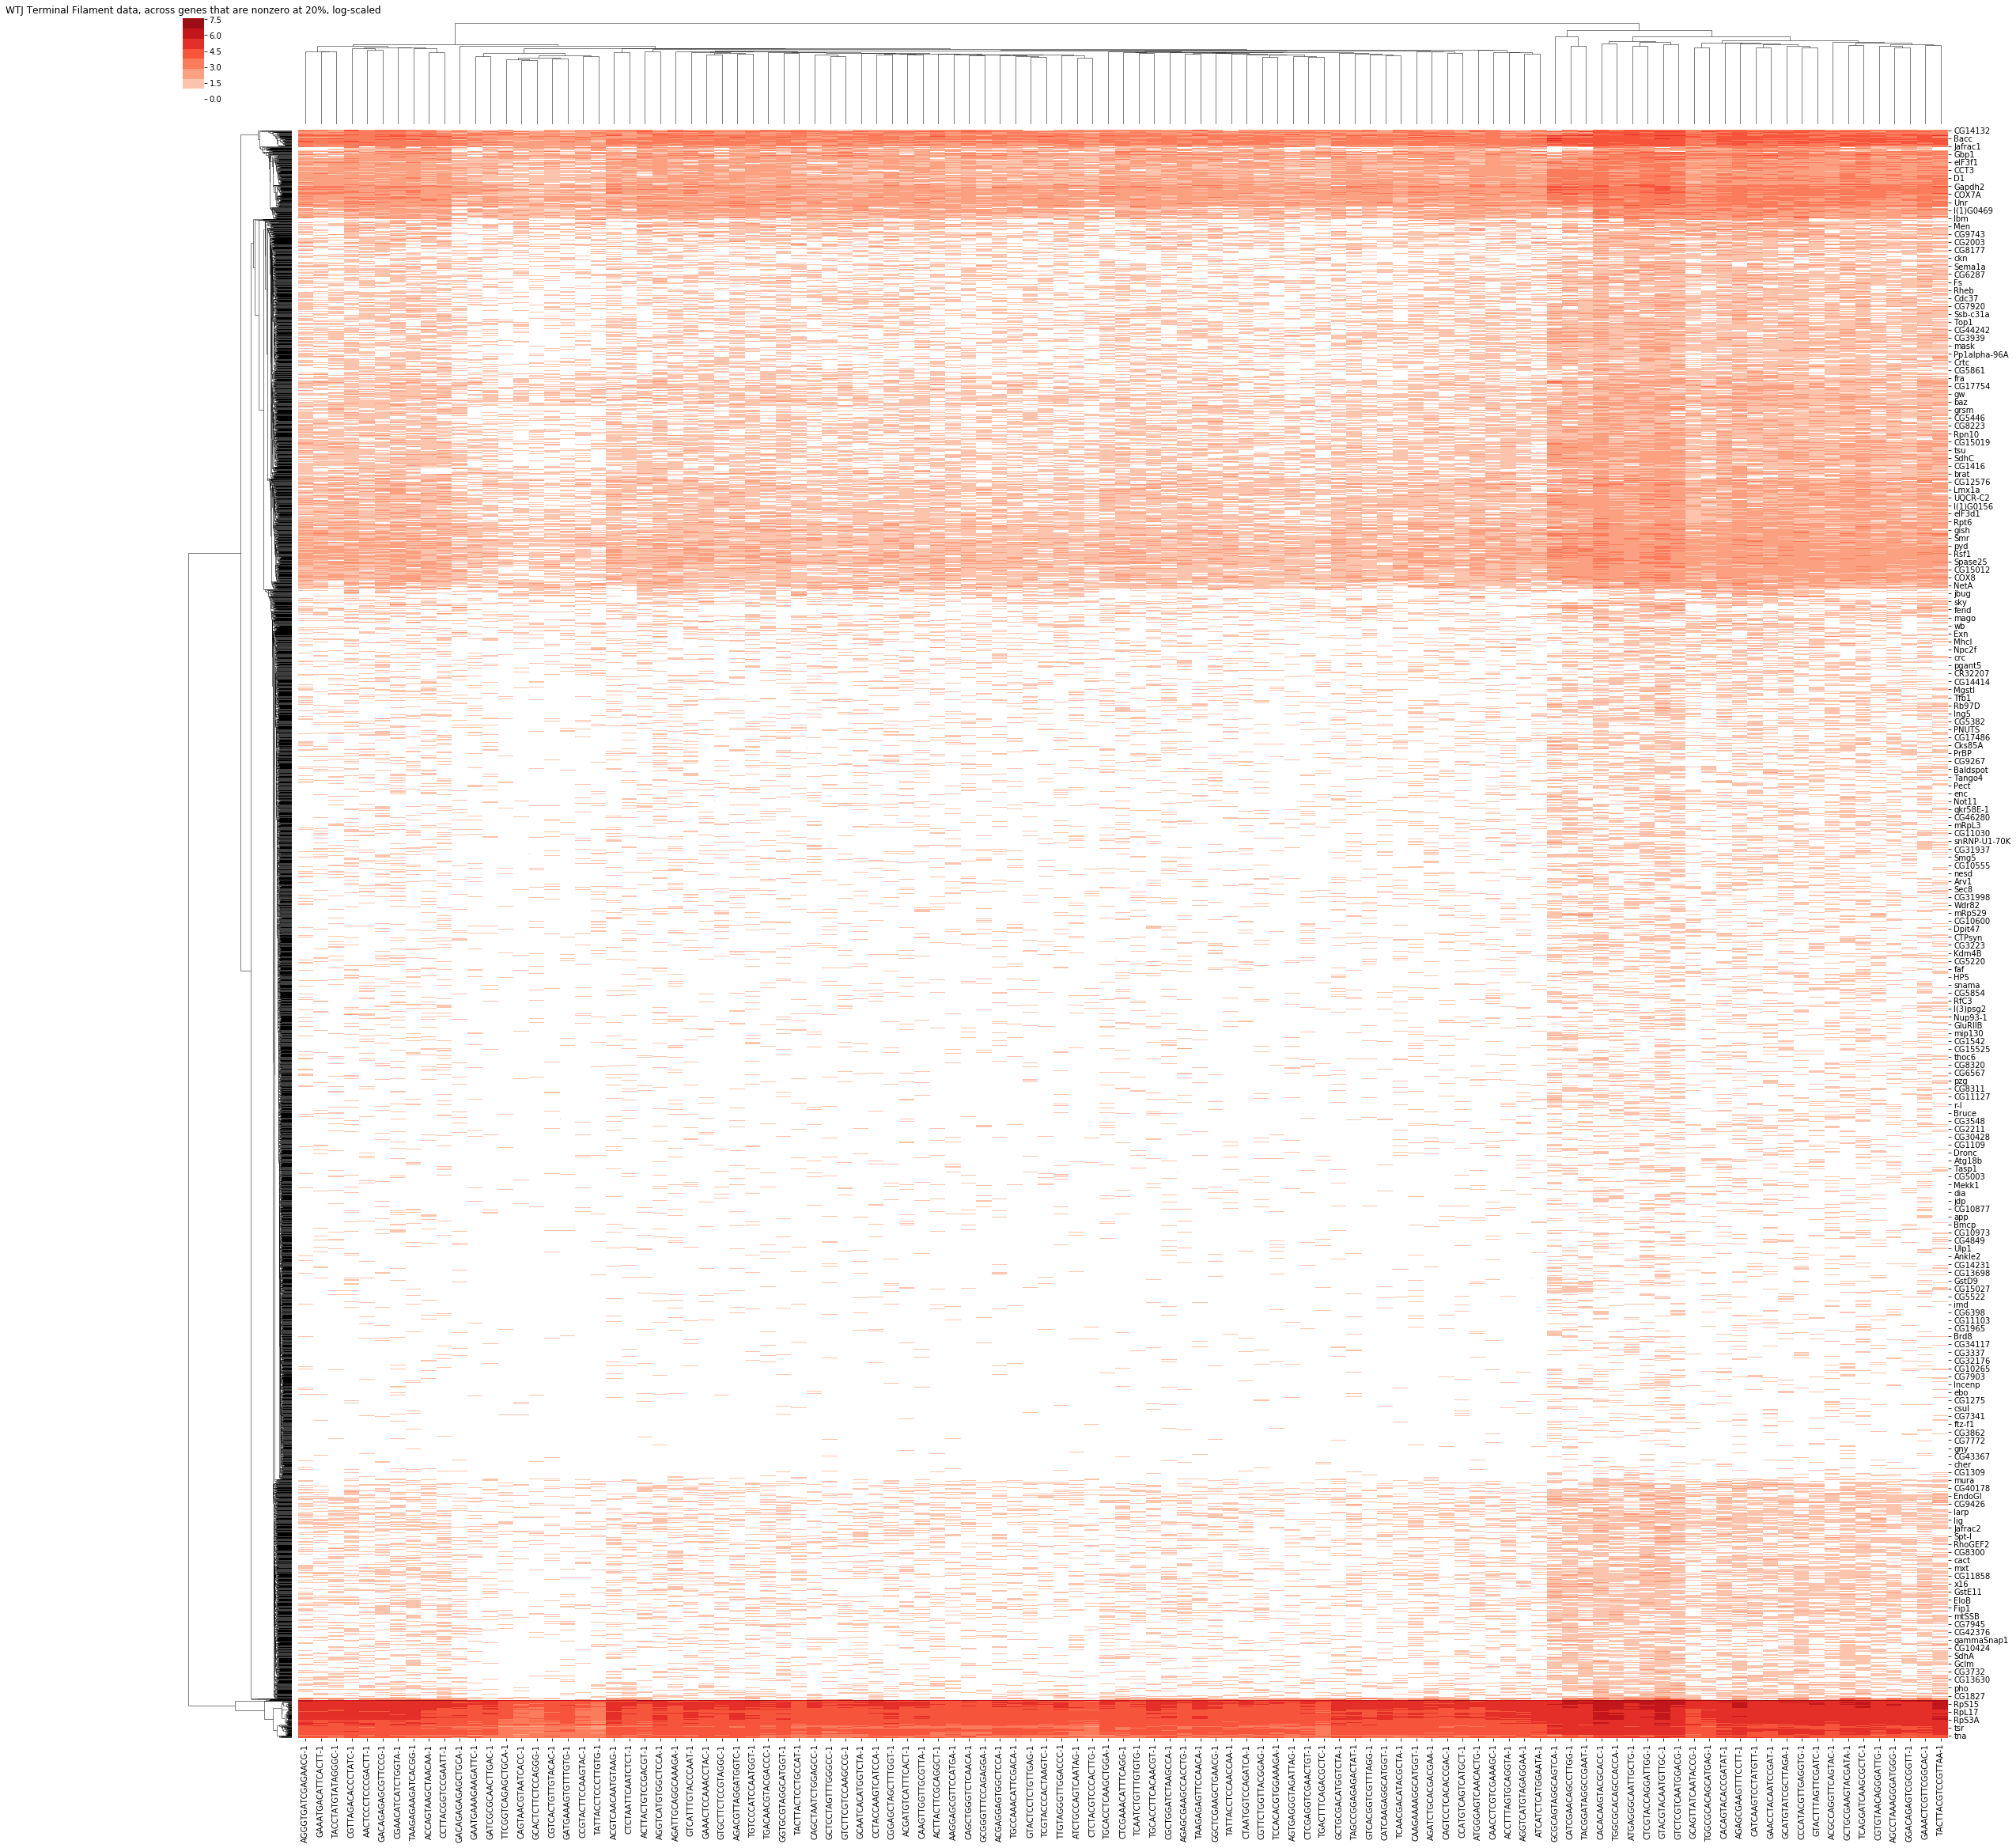

In [42]:
TF_wtJ_percent_nonzero = (raw_data_TF_wtJ > 0).sum(axis = 1) / raw_data_TF_wtJ.shape[1]
raw_data_TF_wtJ_20_percent = raw_data_TF_wtJ.loc[TF_wtJ_percent_nonzero[TF_wtJ_percent_nonzero > .20].index, :]

cluster_obj = sns.clustermap(np.log(raw_data_TF_wtJ_20_percent + 1), cmap=cmap, figsize=(40, 40))
plt.title('WTJ Terminal Filament data, across genes that are nonzero at 20%, log-scaled')

In [45]:
knn_expr = {}
ordered_knn_expr = {}
for k in [3, 5, 7, 10]:
    knn_expr[k] = knn_smoothing(X=raw_data_TF_wtJ_20_percent.values, k=k)
    ordered_knn_expr[k] = knn_expr[k][cluster_obj.dendrogram_row.reordered_ind, :][:, cluster_obj.dendrogram_col.reordered_ind]
raw_expr = raw_data_TF_wtJ_20_percent.values[cluster_obj.dendrogram_row.reordered_ind, :][:, cluster_obj.dendrogram_col.reordered_ind]

Step 1/2: Smooth using k=1
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 2/2: Smooth using k=3
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 1/3: Smooth using k=1
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 2/3: Smooth using k=3
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 3/3: Smooth using k=5
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 1/3: Smooth using k=1
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 2/3: Smooth using k=3
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 3/3: Smooth using k=7
Calculating the pair-wise distances took 0.0 s.
Calculating the

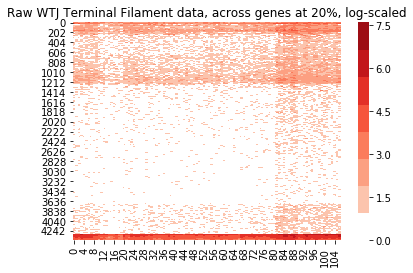

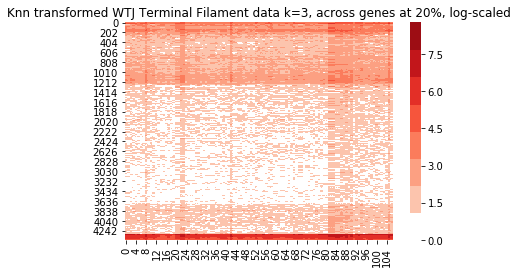

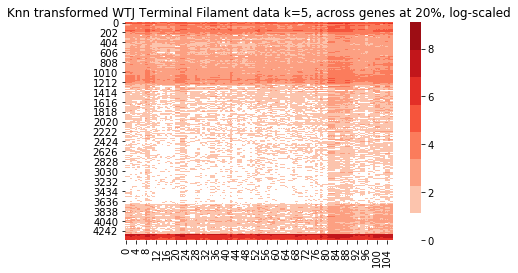

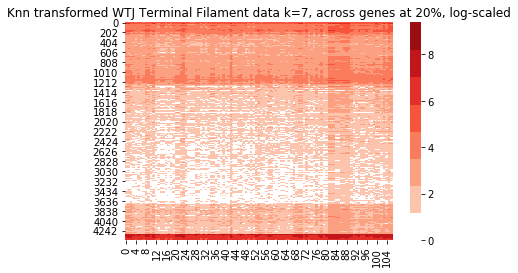

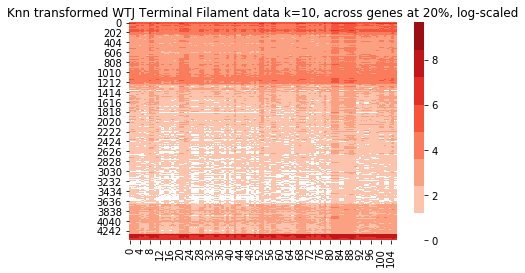

In [47]:
sns.heatmap(np.log(raw_expr + 1), cmap=cmap)
plt.title('Raw WTJ Terminal Filament data, across genes at 20%, log-scaled')
plt.show()
for k in [3, 5, 7, 10]:
    sns.heatmap(np.log(ordered_knn_expr[k] + 1), cmap=cmap)
    plt.title('Knn transformed WTJ Terminal Filament data k={}, across genes at 20%, log-scaled'.format(k))
    plt.show()


Regression with smoothed values of wtJ with k = 3


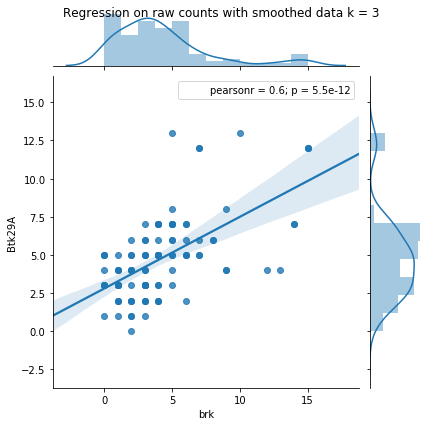

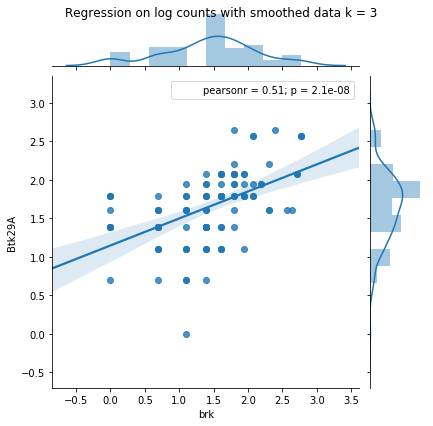

Regression with smoothed values of wtJ with k = 5


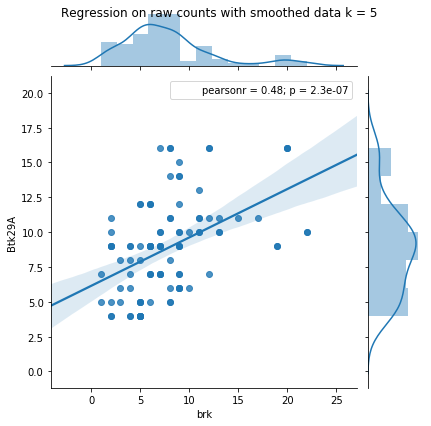

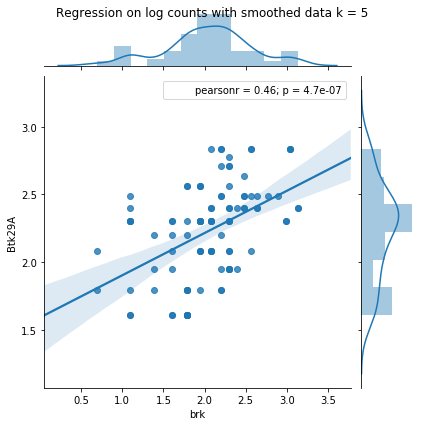

Regression with smoothed values of wtJ with k = 7


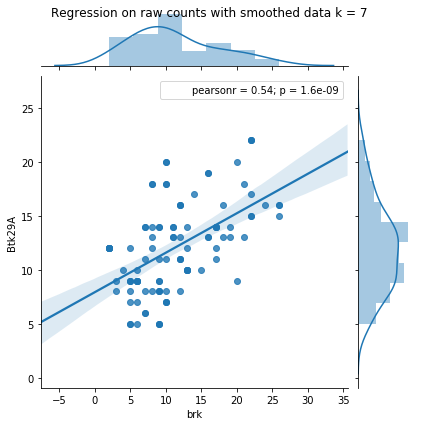

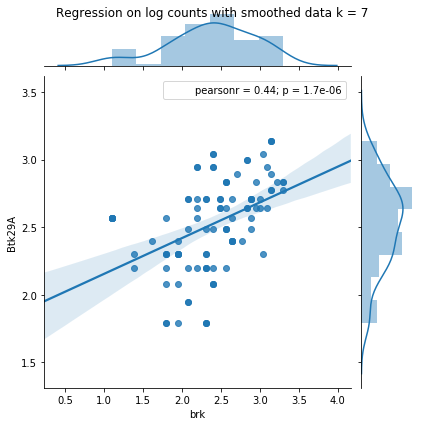

Regression with smoothed values of wtJ with k = 10


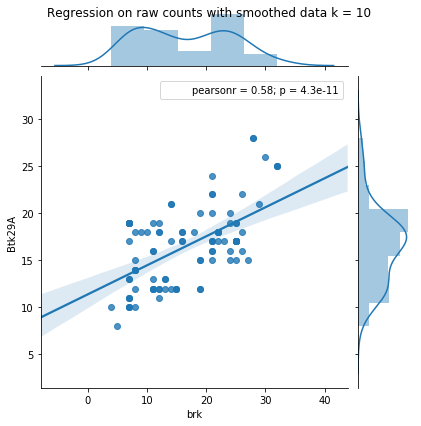

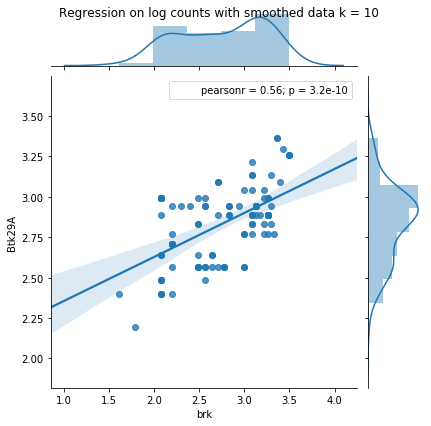

In [48]:
base_df = raw_data_TF_wtJ_20_percent.copy(deep=True)
for k in [3, 5, 7, 10]:
    base_df[base_df.columns] = ordered_knn_expr[k]
    print ('Regression with smoothed values of wtJ with k = {}'.format(k))
    g = sns.jointplot("brk", "Btk29A", data=base_df.transpose(), kind="reg")
    g.fig.suptitle('Regression on raw counts with smoothed data k = {}'.format(k)) # can also get the figure from plt.gcf()
    g = sns.jointplot("brk", "Btk29A", data=np.log(base_df.transpose()+1), kind="reg")
    g.fig.suptitle('Regression on log counts with smoothed data k = {}'.format(k))
    plt.show()
    

## Next Step: Save the KNN transformed data for the 4 different values of k as input to inferelator

Text(0.5,1,'WTF Terminal Filament data, across genes that are nonzero at 20%, log-scaled')

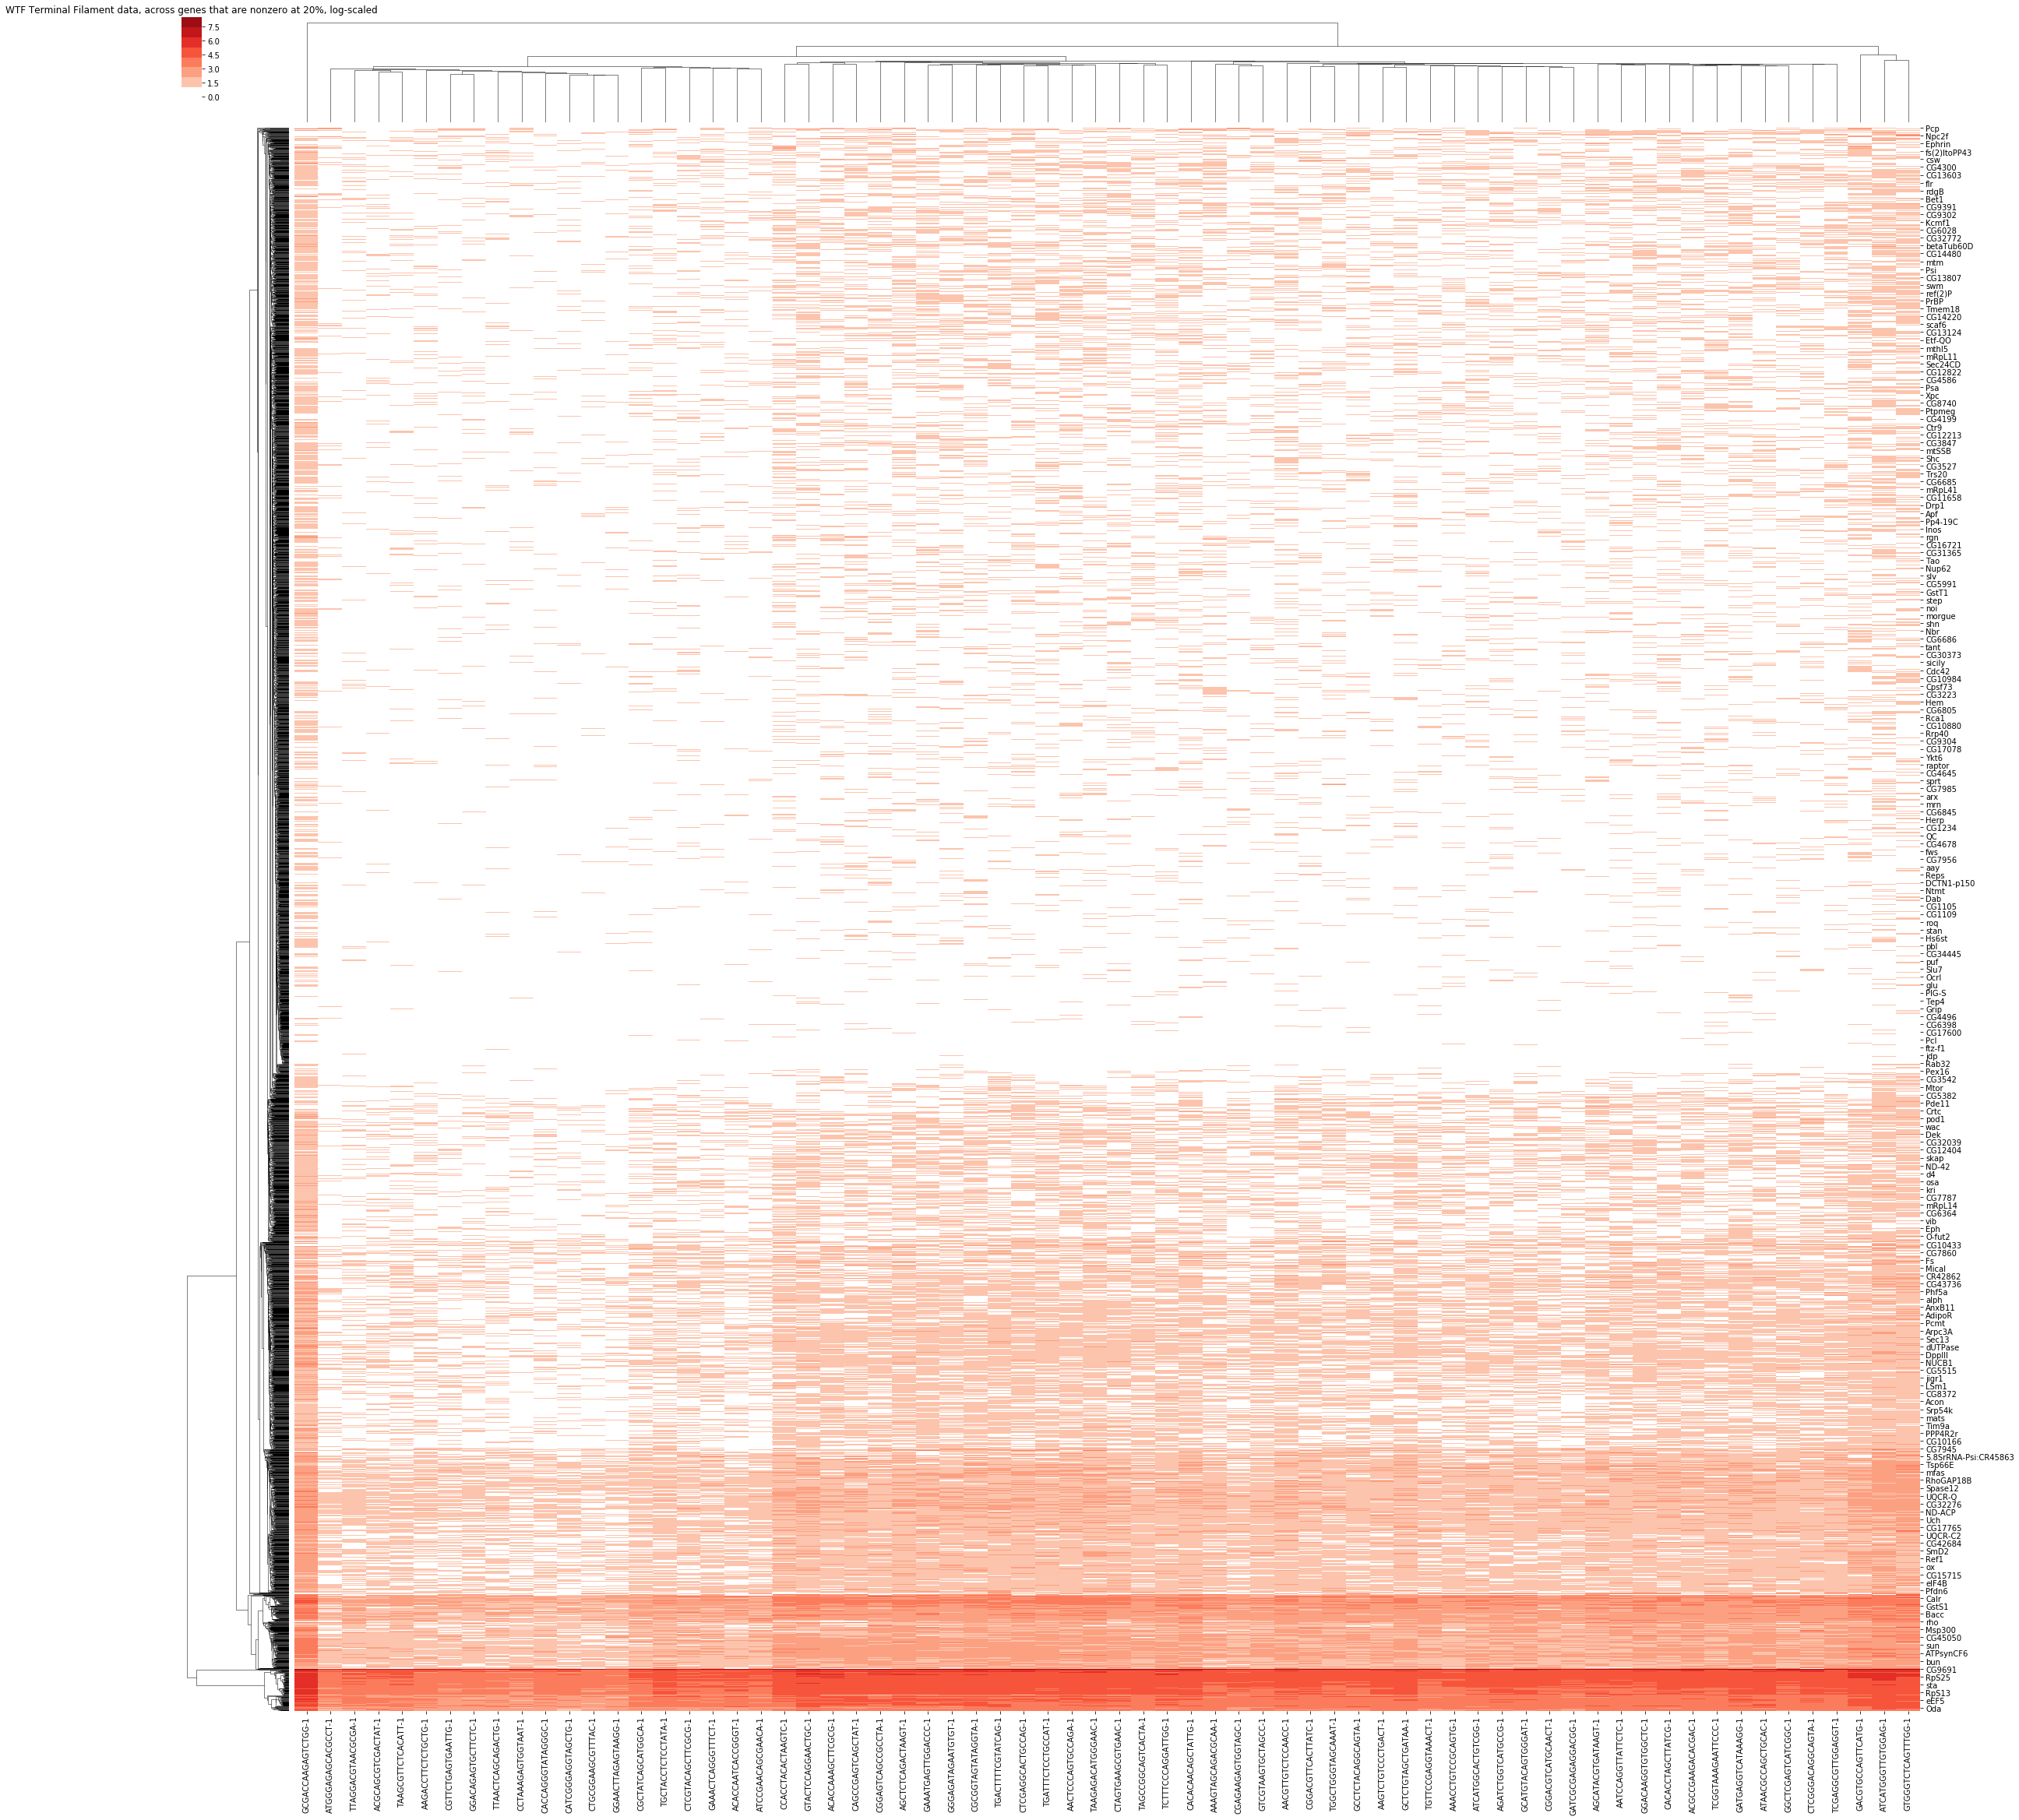

In [52]:
# Due the same treatment to wtF
TF_wtF_percent_nonzero = (raw_data_TF_wtf > 0).sum(axis = 1) / raw_data_TF_wtf.shape[1]
# Use the WtJ 20% cutoff so that the columns match wtJ
raw_data_TF_wtF_20_percent = raw_data_TF_wtf.loc[TF_wtJ_percent_nonzero[TF_wtJ_percent_nonzero > .20].index, :]

cluster_obj = sns.clustermap(np.log(raw_data_TF_wtF_20_percent + 1), cmap=cmap, figsize=(40, 40))
plt.title('WTF Terminal Filament data, across genes that are nonzero at 20%, log-scaled')

In [56]:
wtf_knn_expr = {}
wtf_ordered_knn_expr = {}
for k in [3, 5, 7, 10]:
    wtf_knn_expr[k] = knn_smoothing(X=raw_data_TF_wtF_20_percent.values, k=k)
    wtf_ordered_knn_expr[k] = wtf_knn_expr[k][cluster_obj.dendrogram_row.reordered_ind, :][:, cluster_obj.dendrogram_col.reordered_ind]
raw_expr = raw_data_TF_wtF_20_percent.values[cluster_obj.dendrogram_row.reordered_ind, :][:, cluster_obj.dendrogram_col.reordered_ind]

Step 1/2: Smooth using k=1
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 2/2: Smooth using k=3
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 1/3: Smooth using k=1
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 2/3: Smooth using k=3
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 3/3: Smooth using k=5
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 1/3: Smooth using k=1
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 2/3: Smooth using k=3
Calculating the pair-wise distances took 0.0 s.
Calculating the smoothed expression matrix took 0.0 s.
Step 3/3: Smooth using k=7
Calculating the pair-wise distances took 0.0 s.
Calculating the

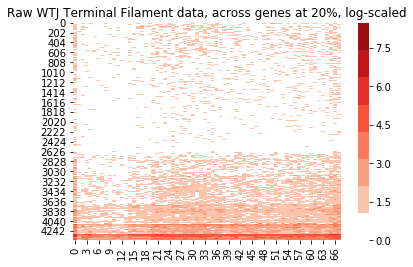

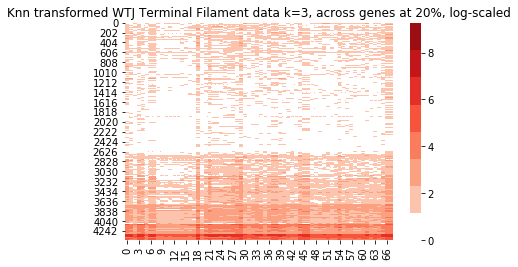

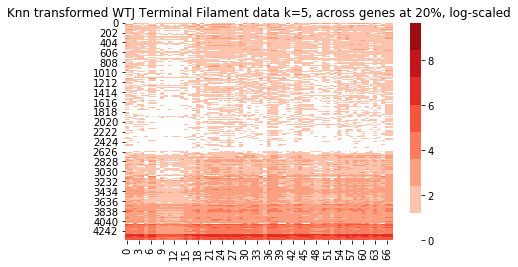

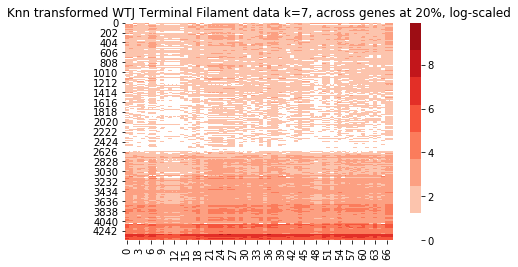

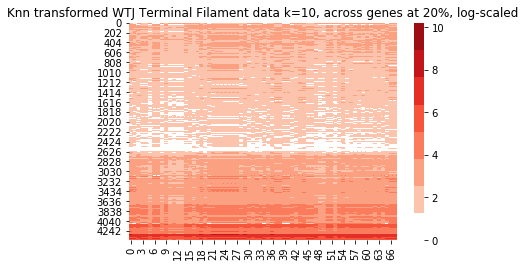

In [57]:
sns.heatmap(np.log(raw_expr + 1), cmap=cmap)
plt.title('Raw WTJ Terminal Filament data, across genes at 20%, log-scaled')
plt.show()
for k in [3, 5, 7, 10]:
    sns.heatmap(np.log(wtf_ordered_knn_expr[k] + 1), cmap=cmap)
    plt.title('Knn transformed WTJ Terminal Filament data k={}, across genes at 20%, log-scaled'.format(k))
    plt.show()

In [80]:
tmp_wtJ_df = raw_data_TF_wtJ_20_percent.copy(deep=True) 
tmp_wtF_df = raw_data_TF_wtF_20_percent.copy(deep=True) 
for k in [3, 5, 7, 10]:
    tmp_wtJ_df[tmp_wtJ_df.columns] = knn_expr[k]
    tmp_wtF_df[tmp_wtF_df.columns] = wtf_knn_expr[k]
    # Write WTJ alone to csv
    convert_df_from_symbols_to_Fbgn_ids(tmp_wtJ_df).to_csv('wtJ_TF_cells_k_{}.tsv'.format(k), sep='\t')
    # Write a concat of the 2 to CSV
    comb = pd.concat([tmp_wtF_df, tmp_wtJ_df], axis=1)
    comb = convert_df_from_symbols_to_Fbgn_ids(comb)
    comb.to_csv('combined_wtJ_and_wtF_TF_cells_smoothed_separately_with_k_{}.tsv'.format(k), sep='\t')

Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430
Converting dataframe. Losing 37 genes out of an index size of 4430


In [79]:
(tmp_wtF_df.index == comb.index).all()

True

In [78]:
comb = pd.concat([tmp_wtF_df, tmp_wtJ_df], axis=1)
comb.shape

(4430, 175)

In [76]:
tmp_wtJ_df.shape

(4430, 107)

In [64]:
tmp_wtJ_df = raw_data_TF_wtJ_20_percent.copy(deep=True) 
tmp_wtF_df = raw_data_TF_wtF_20_percent.copy(deep=True) 
comb = pd.concat([tmp_wtF_df, tmp_wtJ_df])

In [65]:
comb.head()

,AAACCTGTCCGCAGTG-1,AAAGTAGCAGACGCAA-1,AACGTTGTCTCCAACC-1,AACTCCCAGTGCCAGA-1,AACTCCCTCCCGACTT-1,AAGACCTTCTCTGCTG-1,AAGGAGCGTTCCATGA-1,AAGTCTGTCCCTGACT-1,AATCCAGGTTATTCTC-1,ACACCAAAGCTTCGCG-1,...,TGCTACCTCTCCTATA-1,TGGCGCACAGCATGAG-1,TGGCGCACAGCCACCA-1,TGGCTGGGTAGCAAAT-1,TGTCCCATCCAATGGT-1,TGTTCCGAGGTAAACT-1,TTAACTCAGCAGACTG-1,TTAGGACGTAACGCGA-1,TTCGGTCAGAGCTGCA-1,TTGTAGGGTTGGACCC-1
l(2)gl,0.0,2.0,0.0,1.0,NaN,0.0,NaN,1.0,0.0,2.0,...,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
dbr,0.0,0.0,1.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,...,1.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
galectin,2.0,1.0,0.0,2.0,NaN,0.0,NaN,1.0,1.0,1.0,...,0.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN
Zir,0.0,1.0,2.0,1.0,NaN,0.0,NaN,0.0,0.0,2.0,...,0.0,NaN,NaN,1.0,NaN,2.0,0.0,0.0,NaN,NaN
CG11377,1.0,1.0,0.0,1.0,NaN,0.0,NaN,1.0,1.0,2.0,...,1.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [ ]:
sns.heatmap(np.log(ordered_knn_expr + 1), cmap=sns.light_palette("red"))
plt.title('Knn transformed WTJ Terminal Filament data k = 5, across genes at 20%, log-scaled')
plt.show()

In [ ]:
plt.figure(figsize=(40, 40))
sns.heatmap(np.log(df.iloc[1:389, 1:287]))

In [ ]:
sns.clustermap(np.log(filtered_exp_60[wtJ_TF_columns] + 1), cmap=sns.light_palette("red"), figsize=(40, 40))
plt.title('Just WTJ Terminal Filament data, log-scaled')

In [ ]:
plt.figure(figsize=(40, 40))
cluter_obj = sns.clustermap(np.log(filtered_exp_60 + 1), cmap=sns.light_palette("red"), figsize=(40, 40))
plt.title('WTJ data, log-scaled')

In [ ]:
other_cols = list(set(data_frames['wtJ']) -  set(wtJ_TF_columns))
sns.clustermap(np.log(filtered_exp_60[other_cols] + 1), cmap=sns.light_palette("red"), figsize=(40, 40))
plt.title('WTJ minus putative Terminal Filament data, log-scaled')

In [44]:
# from https://github.com/yanailab/knn-smoothing/blob/master/knn_smooth.py
import time
import sys
from math import log, ceil

from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def _freeman_tukey_transform(X):
    """Returns the Freeman-Tukey transformed data."""
    return np.sqrt(X) + np.sqrt(X+1)


def _calculate_pairwise_distances(X, num_jobs=1):
    """Calculates all pairwise distances for X.
    Performs median-normalization and variance stabilization, before
    calculating distances using the Euclidean metric."""
    # median-normalize
    num_transcripts = np.sum(X, axis=0)
    T = (np.median(num_transcripts) / num_transcripts) * X
    # stabilize variance
    F = _freeman_tukey_transform(T)
    # calculate distances
    D = pairwise_distances(F.T, n_jobs=num_jobs, metric='euclidean')
    return D


def knn_smoothing(X, k, num_jobs=1):
    """K-nearest neighbor smoothing.
    Parameters
    ----------
    X : np.ndarray (should of type float/np.float64)
        The UMI count matrix.
    k : int
        The number of nearest neighbors to use for smoothing.
    num_jobs: int
        The number of threads to use. See scikit-learn's
        documentation of the `pairwise_distances` function.
    """
    assert k < X.shape[1], 'Specified k should be smaller than #cells.'
    assert isinstance(X, np.ndarray), 'Input should be a numpy.ndarray.'

    num_powers = int(ceil(log(k+1)/log(2)))
    S = X.copy()

    for p in range(1, num_powers+1):
        k_step = min(pow(2,p)-1, k)
        print('Step %d/%d: Smooth using k=%d'
              % (p, num_powers, k_step)); sys.stdout.flush()

        # determine cell-cell distances based on smoothed matrix
        t0 = time.time()
        D = _calculate_pairwise_distances(S, num_jobs=num_jobs)
        t1 = time.time()
        print('Calculating the pair-wise distances took %.1f s.'
              % (t1-t0)); sys.stdout.flush()

        # sort the distances and generate new smoothed matrix
        t0 = time.time()
        A = np.argsort(D, axis=1, kind='mergesort')
        for j in range(X.shape[1]):
            ind = A[j, :(k_step+1)]
            S[:, j] = np.sum(X[:, ind], axis=1)

        t1 = time.time()
        print('Calculating the smoothed expression matrix took %.1f s.'
              %(t1-t0)); sys.stdout.flush()

    return S

